# Cats and Dogs

Can the AI identify and differentiate between cats and dogs with only a few examples?

Note that this notebook requires umap and umap.plot; you can install both via `pip3 install umap-learn umap-learn[plot]`

This notebook also requires installing `datasets`.

In [1]:
from imgbeddings import imgbeddings
from PIL import Image
import logging
import numpy as np
import datasets
from numpy.random import default_rng
import umap
import umap.plot


logger = logging.getLogger()
logger.setLevel(logging.INFO)


The next cell downloads the famous [Cats vs. Dogs dataset](https://huggingface.co/datasets/cats_vs_dogs) which includes about 23 thousand images; the download is about 800MB.

In [2]:
df = datasets.load_dataset("cats_vs_dogs", split="train", ignore_verifications=True)
df[0:3]

Using custom data configuration default
Reusing dataset cats_vs_dogs (/Users/maxwoolf/.cache/huggingface/datasets/cats_vs_dogs/default/0.0.0/de304955b4952383ceadee4ab96ba2b291f67986bb213efb2255963db39d9ed8)


{'image_file_path': ['/Users/maxwoolf/.cache/huggingface/datasets/downloads/extracted/b89051570a0f8a589a792f42b60396dac7d540bbb4facdd6b48b3fddb3c36c8c/PetImages/Cat/9733.jpg',
  '/Users/maxwoolf/.cache/huggingface/datasets/downloads/extracted/b89051570a0f8a589a792f42b60396dac7d540bbb4facdd6b48b3fddb3c36c8c/PetImages/Cat/63.jpg',
  '/Users/maxwoolf/.cache/huggingface/datasets/downloads/extracted/b89051570a0f8a589a792f42b60396dac7d540bbb4facdd6b48b3fddb3c36c8c/PetImages/Cat/6400.jpg'],
 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=365x500 at 0x155C5F2E0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x15DD1D700>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x240 at 0x15DD1D520>],
 'labels': [0, 0, 0]}

Select 1000 each of random cats (label `0`) and random dogs (label `1`) for a perfectly balanced dataset, as all datasets should be.

In [3]:
n = 1000

rng = default_rng(42)
cat_idx = rng.choice(np.where(np.array(df["labels"]) == 0)[0], n, replace=False)
dog_idx = rng.choice(np.where(np.array(df["labels"]) == 1)[0], n, replace=False)
idx = np.hstack((cat_idx, dog_idx))
rng.shuffle(idx)

idx[0:5]

array([20562, 19877,  5355, 15437, 11539])

In [4]:
img_source = [df[int(x)]["image_file_path"] for x in idx]
images = [df[int(x)]["image"] for x in idx]
labels = [df[int(x)]["labels"] for x in idx]

Preview the images we selected:

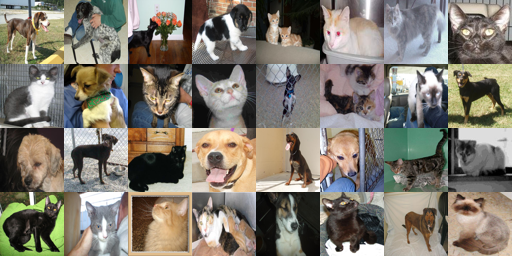

In [5]:
# Show some of the loaded images in a grid:
# https://stackoverflow.com/a/65583584


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

n_rows = 4
n_cols = 8
image_grid([x.resize((64,64)) for x in images[0:(n_rows*n_cols)]], n_rows, n_cols)

In [6]:
print(labels[0:(n_rows*n_cols)])

[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


Now all the images can be converted to embeddings!

In [7]:
ibed = imgbeddings()

In [8]:
embeddings = ibed.to_embeddings(images)

INFO:root:Creating image embeddings in batches of 64.
100%|██████████| 2000/2000 [00:44<00:00, 45.11it/s]


## UMAP unsupervised clustering

umap is a tool that can cluster embeddings (better/more efficient than the popular tSNE) and then visualize the results.

Using cosine similarity works best here.

In [9]:
umap_catsdogs = umap.UMAP(
    n_neighbors=10, n_components=2, metric="cosine", random_state=42
).fit(embeddings)


<AxesSubplot:>

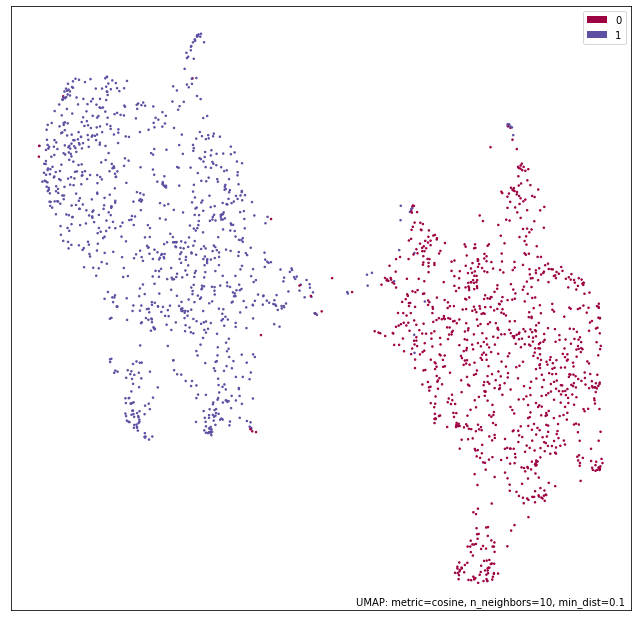

In [10]:
umap.plot.points(umap_catsdogs, labels=np.array(labels))

The two groups are noticeably distinct, although there are several outliers in both cases.

## Cat/Dog Classifier with a simple Logistic Regression

Here's a simple `scikit-learn` binary classifier using the generated embeddings to determine whether an image is a cat or a dog, which is just as simple as any other generic online tutorial.

However, `max_iter` is increased due to the nature of providing raw embeddings vs. tabular data.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

classifier = LogisticRegression(max_iter=500)

In [12]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=test_size, random_state=42, stratify=labels)

In [13]:
classifier.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [14]:
classifier.score(x_test, y_test)

0.995

As expected. For comparison, the [Kaggle Competiton](https://www.kaggle.com/competitions/dogs-vs-cats/leaderboard) for this dataset had a best score of 0.989, although with a different/larger validation set, and without the power of modern AI frameworks.

Let's look at misclassified images by finding the indices of where the predictions were incorrect.

In [15]:
predicted = classifier.predict(x_test)
idx_mismatch = np.where(y_test != predicted)
idx_mismatch


(array([198, 358]),)

Map those indicies back to the original 2000 image dataset.

In [16]:
# https://stackoverflow.com/a/51352806
misclass_idx = np.where((embeddings[:, None] == x_test[idx_mismatch]).all(-1).any(-1))
misclass_idx

(array([1214, 1423]),)

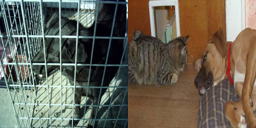

In [17]:
n_rows = 1
n_cols = len(list(misclass_idx[0]))
image_grid([images[x].resize((128,128)) for x in list(misclass_idx[0])], n_rows, n_cols)

The first image is interesting: the cage bars "mask" the image of the dog which explain how the model may get confused.

The second image however is shennanigans: putting both a dog and a cat in the same image is cheating IMO.